In [19]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import NuSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [20]:
def remove_number(sentence):
    words = []
    for word in sentence.split():
        if word.isdigit(): continue
        words.append(word)
    return ' '.join(words)

def remove_stop_words(sentence, stop_words):
    words = []
    for word in sentence.split():
        if word in stop_words: continue
        words.append(word)
    return ' '.join(words)

def unconvert(dict, value):
    for k, v in dict.items():
        if value == v:
            return k
    return "Key không tồn tại"

In [21]:
df = pd.read_csv('../Data/Data_best.csv')

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20224 entries, 0 to 20223
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  20224 non-null  int64 
 1   Tiêu đề     20224 non-null  object
 2   Danh mục    20224 non-null  object
dtypes: int64(1), object(2)
memory usage: 474.1+ KB


In [23]:
df['Danh mục'].value_counts()

Danh mục
Kinh tế     2419
Văn hóa     2400
Xe          2387
Sức khỏe    2331
Giải trí    2299
Đời sống    2289
Thế giới    2191
Giáo dục    2107
Giới trẻ    1801
Name: count, dtype: int64

In [24]:
with open('../Data/vietnamese_stop_words.txt', 'r', encoding='utf-8') as st:
    stop_words = st.read().split('\n')

X = df['Tiêu đề'].apply(lambda x: x.lower())
X = X.apply(lambda x: remove_number(x))
X = X.apply(lambda x: remove_stop_words(x, stop_words))
y = df['Danh mục']

In [25]:
# Chuyển đổi nhãn sang số nguyên
category_dict = {key: i for i, (key, value) in enumerate(y.value_counts().items(), start=1)}
y_encoded = y.map(category_dict).to_numpy()

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

0        hàng loạt trưởng peru chức bê bối đồng hồ role...
1                 tàu cảnh sát biển ấn độ cập cảng sài gòn
2           trump nộp tiền bảo lãnh, nguy tịch thu tài sản
3        tòa kiến nghị hủy cáo buộc trốn thuế trai tổng...
4                          hun sen chia quốc hội campuchia
                               ...                        
20219    xe ga benelli panarea giá 1.600 usd, cạnh tran...
20220    xe tải toyota hilux rục rịch trở việt nam, đại...
20221    dân mạng ngao ngán ‘nữ ninja’ lái xe máy cầm d...
20222    ô tô điện mg4 giá rẻ vinfast vf e34, chờ việt nam
20223                 ưu đãi 100% lệ phí bạ mua honda cr-v
Name: Tiêu đề, Length: 20224, dtype: object

In [26]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [27]:
X_train_tfidf.shape

(16179, 5000)

In [28]:
X_test_tfidf.shape

(4045, 5000)

In [29]:
y_train

array([7, 6, 7, ..., 6, 7, 5])

In [30]:
# Huấn luyện mô hình
model = NuSVC(kernel='rbf', gamma='scale', probability=True, class_weight='balanced', nu=0.1)
model.fit(X_train_tfidf, y_train)

NuSVC(class_weight='balanced', nu=0.1, probability=True)

In [31]:
# Dự đoán và đánh giá
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f'Độ chính xác: {accuracy}')

Độ chính xác: 0.8202719406674908


In [32]:
print(classification_report(y_test, y_pred, target_names=category_dict.keys()))

              precision    recall  f1-score   support

     Kinh tế       0.79      0.84      0.81       511
     Văn hóa       0.71      0.73      0.72       496
          Xe       0.95      0.95      0.95       453
    Sức khỏe       0.89      0.90      0.90       472
    Giải trí       0.83      0.84      0.83       477
    Đời sống       0.75      0.68      0.72       461
    Thế giới       0.88      0.86      0.87       391
    Giáo dục       0.91      0.88      0.89       418
    Giới trẻ       0.68      0.69      0.68       366

    accuracy                           0.82      4045
   macro avg       0.82      0.82      0.82      4045
weighted avg       0.82      0.82      0.82      4045



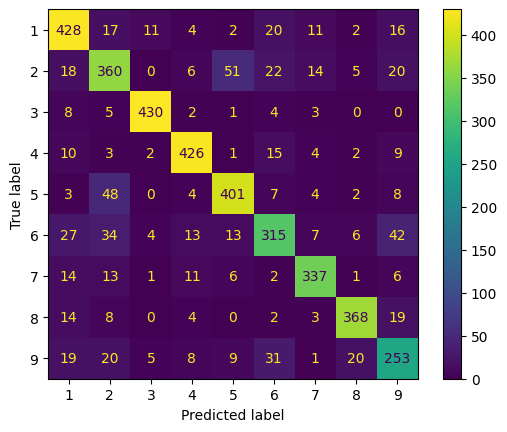

In [33]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

In [34]:
test_case = ['Người dân giảm gửi tiền, ngân hàng tăng lãi suất tiết kiệm',
             'BST áo dài "Huyền sử Thăng Long" có phiên bản mới sau 24 năm',
             'Quy định mới về đào tạo lái xe hạng B1, B2, C áp dụng từ ngày 1.6.2024',
             'Điều trị thành công cho bệnh nhân bị liệt, đau thần kinh suốt 18 năm',
             'Hồng Vân xót xa cô vợ trẻ chịu thiệt thòi khi lấy chồng khó tính',
             'Những đứa trẻ tự kỷ làm nên điều kỳ diệu: Nghề nghiệp đưa con vào đời',
             'Nước lũ bao vây nhiều vùng tại Nga và Kazakhstan, hàng vạn người sơ tán',
             'Giám đốc Sở GD-ĐT TP.HCM gửi thư ngỏ đến phụ huynh Trường quốc tế AISVN',
             'Công trình thanh niên giúp phòng, chống tụ tập đông người gây rối an ninh, trật tự']

test_case_pred = model.predict(tfidf_vectorizer.transform(test_case))
for i, case in enumerate(test_case, start=1):
    print(f'Văn bản: {case}, Nhãn dự đoán: {unconvert(category_dict ,test_case_pred[i-1])}, Nhãn chính xác: {unconvert(category_dict , i)}')
    print('Đúng!') if unconvert(category_dict ,test_case_pred[i-1]) == unconvert(category_dict , i) else print('Sai =))))')

Văn bản: Người dân giảm gửi tiền, ngân hàng tăng lãi suất tiết kiệm, Nhãn dự đoán: Kinh tế, Nhãn chính xác: Kinh tế
Đúng!
Văn bản: BST áo dài "Huyền sử Thăng Long" có phiên bản mới sau 24 năm, Nhãn dự đoán: Văn hóa, Nhãn chính xác: Văn hóa
Đúng!
Văn bản: Quy định mới về đào tạo lái xe hạng B1, B2, C áp dụng từ ngày 1.6.2024, Nhãn dự đoán: Xe, Nhãn chính xác: Xe
Đúng!
Văn bản: Điều trị thành công cho bệnh nhân bị liệt, đau thần kinh suốt 18 năm, Nhãn dự đoán: Sức khỏe, Nhãn chính xác: Sức khỏe
Đúng!
Văn bản: Hồng Vân xót xa cô vợ trẻ chịu thiệt thòi khi lấy chồng khó tính, Nhãn dự đoán: Giải trí, Nhãn chính xác: Giải trí
Đúng!
Văn bản: Những đứa trẻ tự kỷ làm nên điều kỳ diệu: Nghề nghiệp đưa con vào đời, Nhãn dự đoán: Văn hóa, Nhãn chính xác: Đời sống
Sai =))))
Văn bản: Nước lũ bao vây nhiều vùng tại Nga và Kazakhstan, hàng vạn người sơ tán, Nhãn dự đoán: Thế giới, Nhãn chính xác: Thế giới
Đúng!
Văn bản: Giám đốc Sở GD-ĐT TP.HCM gửi thư ngỏ đến phụ huynh Trường quốc tế AISVN, Nhãn dự đ

In [36]:
joblib.dump((model, tfidf_vectorizer, category_dict), "model.joblib")

['model.joblib']